# ERA Interim Climatology

This script analyzes and visualizes the ERA Interim data on which the simulations will be based. The objective of this script is to identify reasonable distributions for water vapor and temperature profiles so that the prior distributions can be expressed in closed form. This is necessary to ensure that the true a posteriori distribution can be approximated with MCMC simulations.

In [1]:
import matplotlib_settings
import matplotlib.pyplot as plt
import numpy as np

## Scalar Data

Here we just have a brief look at the scalar data, which is not directly relevant for the simulations but is useful for a brief overview over the dataset. Also the distribution of column water vapor can later be used to check the fitted distributions of temperature and water vapor profiles.

In [3]:
from netCDF4 import Dataset
dataset_suffix = "_summer"
rootgrp = Dataset("data/era_interim_mid_latitudes_2016" +
                  dataset_suffix + "_sst_cwv.nc")
sst_grid = rootgrp.variables['sst']
cwv_grid = rootgrp.variables['tcwv']
lat     = rootgrp.variables['latitude']
lon     = rootgrp.variables['longitude']

### Sea Surface Temperature

In [4]:
sst_mean_grid = np.mean(sst_grid, axis = 0)
sst_mean_grid.mask = sst_mean_grid == sst_mean_grid.fill_value
sst_mean  = np.mean(sst_mean_grid)
sst_sigma = np.std(np.asarray(sst_grid)[np.logical_not(sst_grid == sst_grid.missing_value)])

np.save("data/sst_mean", sst_mean)
np.save("data/sst_sigma", sst_sigma)

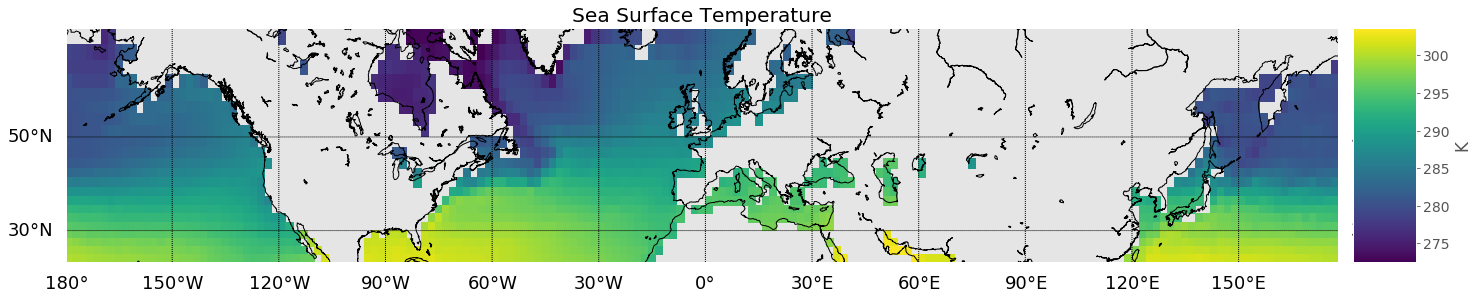

In [5]:
from ipywidgets import interact, interactive
from mpl_toolkits.basemap import Basemap

def plot_color_map(z, title, unit = None):
    fig = plt.figure(figsize = (20, 8))
    llat = np.min(lat)
    ulat = np.max(lat)
    llon = np.min(lon)
    ulon = np.max(lon)
    m = Basemap(llcrnrlon = llon, llcrnrlat = llat, urcrnrlon = ulon, urcrnrlat = ulat,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
    m.drawcoastlines()
    LON, LAT = np.meshgrid(lon, lat)
    x, y = m(LON, LAT)
    mappable = plt.gca().pcolormesh(x, y, z)
    m.drawparallels(np.arange(10, 90, 20),
                    labels=[1, 1, 0, 1],
                    fontsize = 18)
    m.drawmeridians(np.arange(-180, 180, 30),
                    labels = [1, 1, 0, 1],
                    fontsize = 18)
    
    plt.gca().set_title(title)
    m.colorbar(mappable, pad=0.2, label = unit)
    plt.tight_layout()
    
plot_color_map(sst_mean_grid, "Sea Surface Temperature", unit = "K")

### Column Water Vapor

In [6]:
cwv_grid_mean = np.mean(cwv_grid, axis = 0)
cwv_mean  = np.mean(cwv_grid_mean)

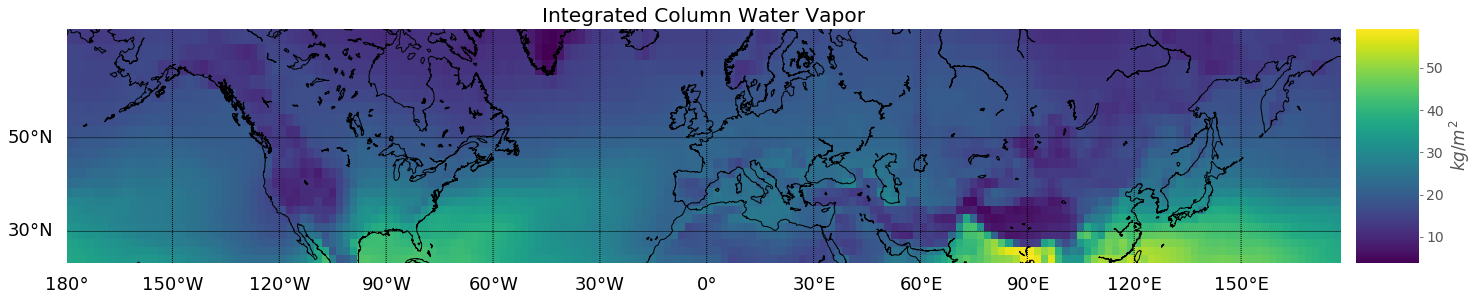

In [7]:
plot_color_map(cwv_grid_mean, "Integrated Column Water Vapor", unit = "$kg / m^2$")

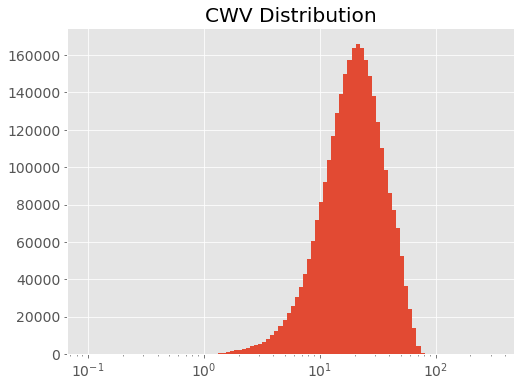

In [8]:
bins = np.logspace(-1, 2.5, 101)
plt.hist(np.asarray(cwv_grid).ravel(), bins = bins)
plt.xscale("log")
plt.title("CWV Distribution")

## Atmospheric Profiles

The radiative transfer simulations are performed in one dimension and the atmospheric state is fully described by the corresponding **temperature** and **water vapor** profiles.

In [9]:
from netCDF4 import Dataset
rootgrp = Dataset("data/era_interim_mid_latitudes_2016" +
                  dataset_suffix + ".nc")
level   = rootgrp.variables['level']
lat     = rootgrp.variables['latitude']
lon     = rootgrp.variables['longitude']
q_grid  = rootgrp.variables['q']
t_grid  = rootgrp.variables['t']

### Pressure Grid

We interpolate the pressure grid to a uniform grid with 15 points.

In [10]:
p = rootgrp.variables['level']
p_array = np.array(p)
p_interp = np.interp(np.linspace(p[0], p[-1], 15), p_array, p_array)
np.save("data/p_grid", p_interp)

### Extraction of Profiles

In [13]:
def running_mean_2(x):
    res = np.copy(x)
    cs = np.cumsum(x)
    res[1:-1] = 0.5 * (cs[2:] - cs[:-2])
    return res

In [14]:
n_levels = p_interp.shape[0]
q_profiles = np.zeros((q_grid.shape[0] * q_grid.shape[2] * q_grid.shape[3], n_levels))
t_profiles = np.zeros((t_grid.shape[0] * t_grid.shape[2] * t_grid.shape[3], n_levels))

p_smooth = running_mean_2(p)

ind = 0
for i in range(q_grid.shape[0]):
    for j in range(q_grid.shape[2]):
        for k in range(q_grid.shape[3]):
            q_smooth = running_mean_2(q_grid[i, :, j, k].ravel())
            q_profiles[ind, :]  = np.interp(p_interp, p_smooth, q_smooth)
            t_smooth = running_mean_2(t_grid[i, :, j, k].ravel())
            t_profiles[ind, :]  = np.interp(p_interp, p_smooth, t_smooth)
            ind += 1
            
np.save("data/q_profiles" + dataset_suffix, q_profiles)
np.save("data/t_profiles" + dataset_suffix, t_profiles)

In [ ]:
q_profiles  = np.load("data/q_profiles" + dataset_suffix + ".npy")
t_profiles  = np.load("data/t_profiles" + dataset_suffix + ".npy")

We sample random profiles and plot the smoothed against the true profile to ensure that our smoothing performs as expected.

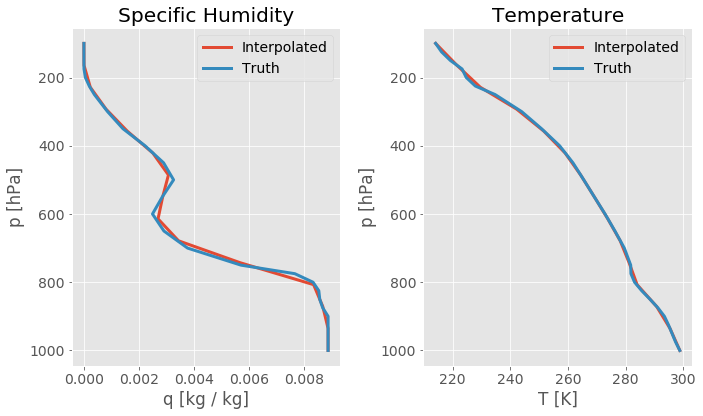

In [66]:
f, axs = plt.subplots(1, 2, figsize = (10, 6))

i = np.random.randint(0, q_profiles.shape[0])
j = i // (180 * 23)
k = (i // 180) % 23
l = i % 180

axs[0].set_title("Specific Humidity")
axs[0].plot(q_profiles[i, :], p_interp, label = "Interpolated", lw = 3)
axs[0].plot(q_grid[j, :, k, l].ravel(), p, label = "Truth", lw = 3)
axs[0].invert_yaxis()
axs[0].set_xlabel("q [kg / kg]")
axs[0].set_ylabel("p [hPa]")
axs[0].legend()

axs[1].set_title("Temperature")
axs[1].plot(t_profiles[i, :], p_interp, label = "Interpolated", lw = 3)
axs[1].plot(t_grid[j, :, k, l].ravel(), p, label = "Truth", lw = 3)
axs[1].invert_yaxis()
axs[1].set_xlabel("T [K]")
axs[1].set_ylabel("p [hPa]")
axs[1].legend()

f.tight_layout()

### Mean Profiles

In [49]:
q_mean  = np.mean(q_profiles, axis = 0)
t_mean  = np.mean(t_profiles, axis = 0)

np.save("data/q_mean" + dataset_suffix,  q_mean)
np.save("data/t_mean" + dataset_suffix,  t_mean)

To get an idea of the variability of the profiles, we plot the means and 500 randomly chosen samples with reduced alpha value.

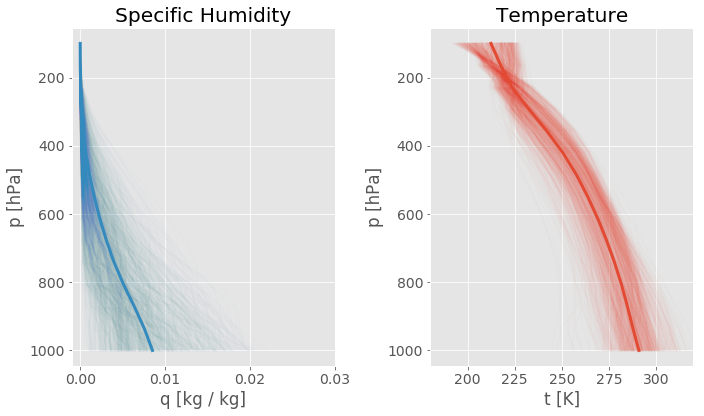

In [63]:
f, axs = plt.subplots(1, 2, figsize = (10, 6))
ps = np.arange(1, 28)[::-1]

axs[0].set_ylabel("p [hPa]")
axs[0].set_xlabel("q [kg / kg]")
axs[0].set_title("Specific Humidity")
axs[0].invert_yaxis()
for i in range(1000):
    ind = np.random.randint(0, q_profiles.shape[0])
    axs[0].plot(q_profiles[ind, :].ravel(), p_interp, c = 'C1', alpha = 0.01)
axs[0].plot(q_mean.ravel(), p_interp, c = 'C1', lw = 3)
axs[0].set_xlim([-0.001, 0.03])


axs[1].set_ylabel("p [hPa]")
axs[1].set_xlabel("t [K]")
axs[1].set_title("Temperature")
axs[1].invert_yaxis()
for i in range(1000):
    ind = np.random.randint(0, t_profiles.shape[0])
    axs[1].plot(t_profiles[ind, :].ravel(), p_interp, c = 'C0', alpha = 0.01)
axs[1].plot(t_mean.ravel(), p_interp, c = 'C0', lw = 3)
axs[1].set_xlim([180, 320])

plt.tight_layout()

### Covariance Matrices

We compute covariance matrices for each quantity separately as well as the covariance matrix for the joint distritbuion of both profiles. This may help avoiding unphysical states taking into account correlations between temperature and specific humidity.

In [68]:
q_profiles  = np.load("data/q_profiles" + dataset_suffix + ".npy")
q_mean      = np.load("data/q_mean" + dataset_suffix + ".npy")
t_profiles  = np.load("data/t_profiles" + dataset_suffix + ".npy")
t_mean      = np.load("data/t_mean" + dataset_suffix + ".npy")

In [69]:
q_log_cov = np.cov(np.log(np.maximum(q_profiles, 1e-9)) , rowvar = False)
t_cov = np.cov(np.maximum(t_profiles, 1e-9), rowvar = False)
np.save("data/q_log_cov" + dataset_suffix, q_log_cov)
np.save("data/t_cov" + dataset_suffix, t_cov)

In [70]:
q_log_mean = np.mean(np.log(np.maximum(q_profiles, 1e-9)), axis = 0)
t_log_mean = np.mean(np.log(np.maximum(t_profiles, 1e-9)), axis = 0)
np.save("data/q_log_mean" + dataset_suffix, q_log_mean)
np.save("data/t_log_mean" + dataset_suffix, t_log_mean)

### Combined Climatology

In [71]:
qt_profiles = np.concatenate([np.log(np.maximum(q_profiles, 1e-9)), t_profiles], axis = 1)
qt_mean     = np.mean(qt_profiles, axis = 0)
qt_cov      = np.cov(qt_profiles, rowvar = False)

In [72]:
np.save("data/qt_profiles" + dataset_suffix, qt_profiles)
np.save("data/qt_cov" + dataset_suffix, qt_cov)

In [73]:
np.save("data/qt_mean" + dataset_suffix, qt_mean)